<a href="https://colab.research.google.com/github/gsdev42/SE206n-diabetes-prediction/blob/main/diabetes_prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install imbalanced-learn

In [38]:
pip install imbalanced-learn xgboost

In [34]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [4]:
# LOAD DATASET
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv(url, names=column_names)

In [6]:
# EXPLORE DATASET
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [7]:
print("\nDataset Summary Statistics:")
print(df.describe())


Dataset Summary Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min   

In [8]:
print("\nCheck for missing values:")
print(df.isnull().sum())


Check for missing values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [9]:
# Check for zeros in columns where zero doesn't make sense
print("\nZero values count in each column:")
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    zero_count = len(df[df[column] == 0])
    print(f"{column}: {zero_count} zeros ({zero_count/len(df)*100:.2f}%)")


Zero values count in each column:
Glucose: 5 zeros (0.65%)
BloodPressure: 35 zeros (4.56%)
SkinThickness: 227 zeros (29.56%)
Insulin: 374 zeros (48.70%)
BMI: 11 zeros (1.43%)


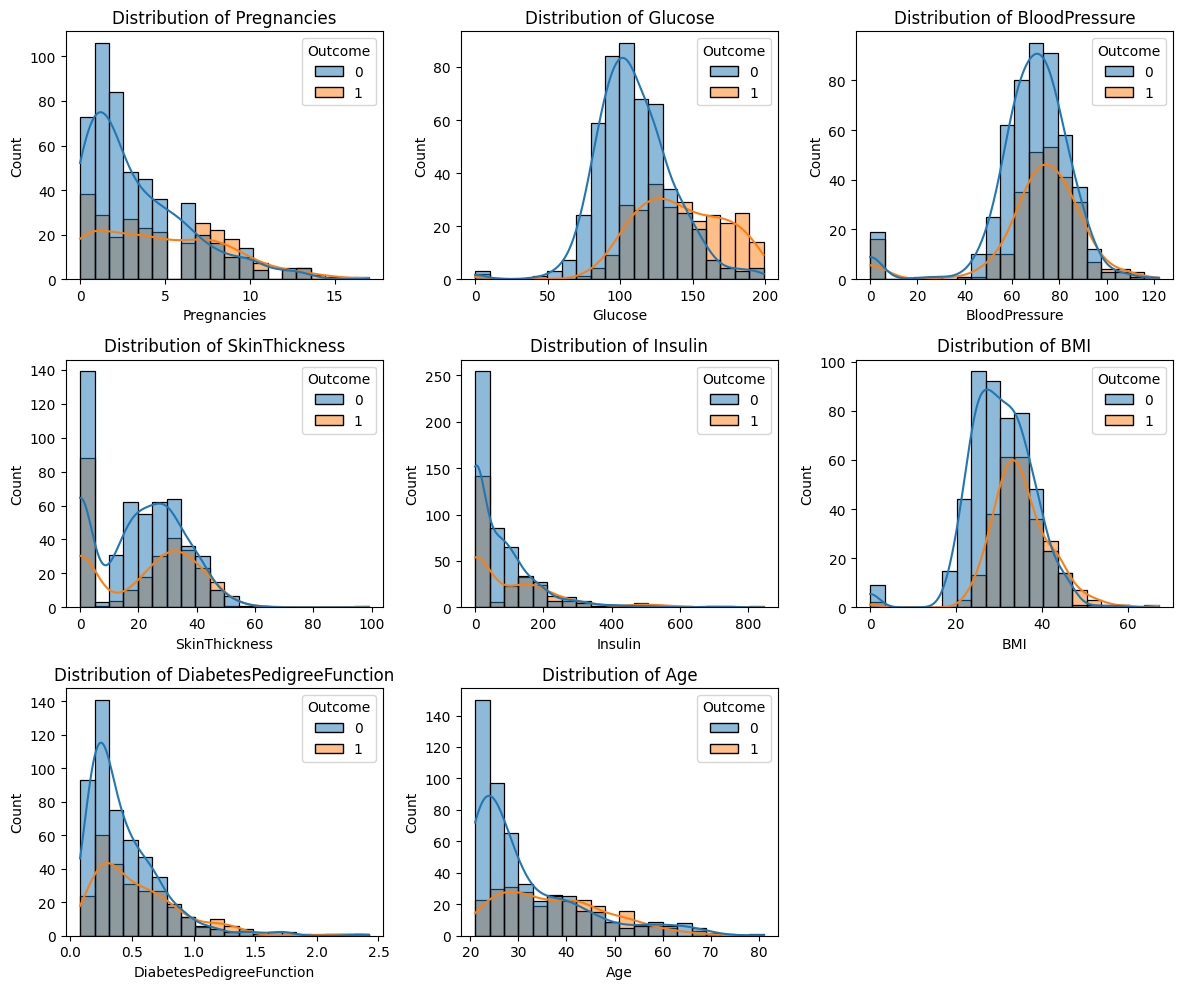

In [10]:
# distributions
plt.figure(figsize=(12, 10))
features_to_plot = df.columns[:-1]
for position, feature_name in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, position)

    sns.histplot(
        data=df,
        x=feature_name,
        hue='Outcome',
        kde=True,
        bins=20
    )

    plt.title(f'Distribution of {feature_name}')
plt.tight_layout()

plt.savefig('feature_distributions.png')
plt.show()

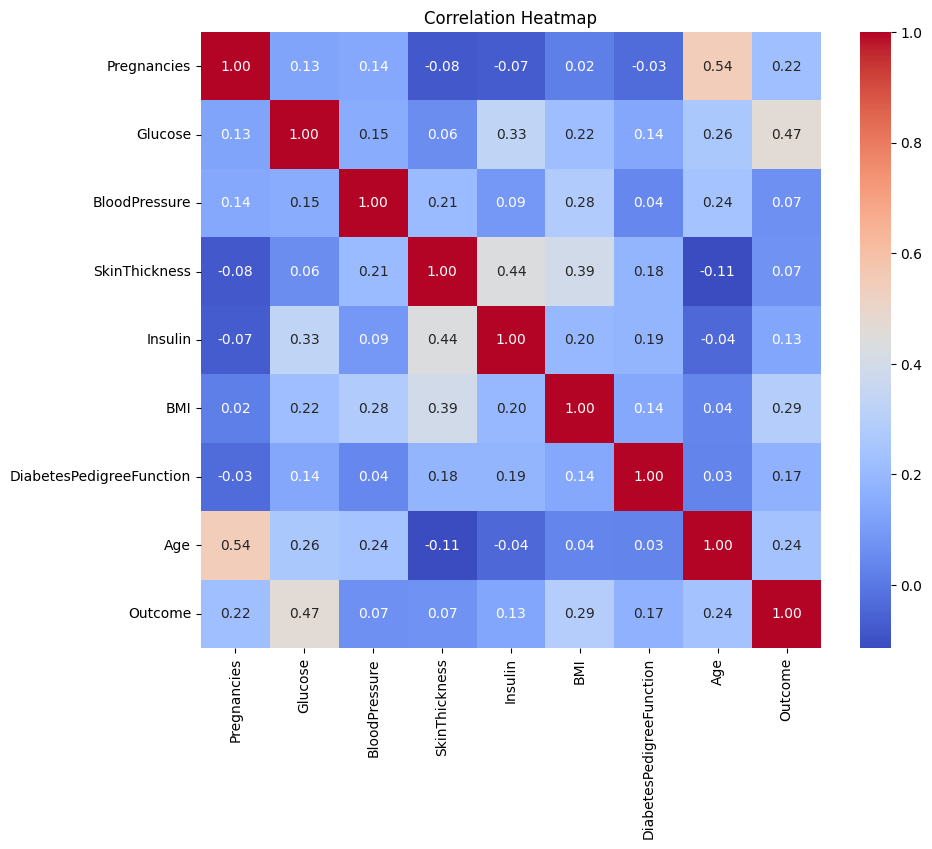

In [11]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')

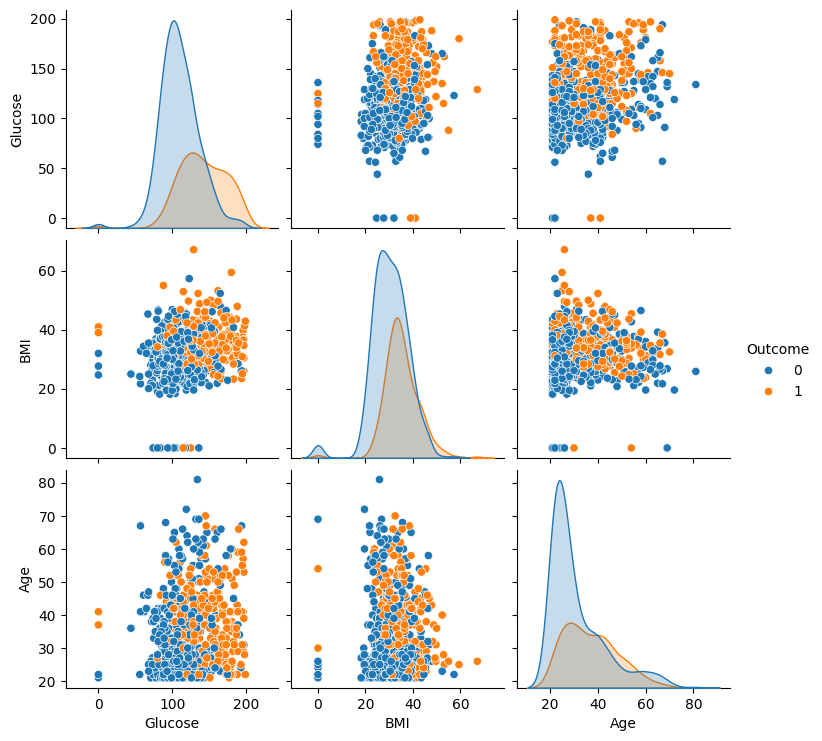

In [12]:
# Pairplot
sns.pairplot(df[['Glucose', 'BMI', 'Age', 'Outcome']], hue='Outcome')
plt.savefig('pairplot.png')

In [13]:
# DATA PREP
# Replace zeros with NaN in columns where zero is not valid
columns_to_modify = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for column in columns_to_modify:
    df[column] = df[column].replace(0, np.nan)

In [14]:
# Handle missing values by replacing with median
for column in columns_to_modify:
    median_value = df[column].median()
    df[column] = df[column].fillna(median_value)

In [15]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [16]:
# SPLIT DATASET
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [36]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


In [31]:
# TRAIN MODELS
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=142),
    'KNeighbors Classifier': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'XGBoost Classifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


results = {}

In [32]:
# VALIDATION & EVALUATION METRICS
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
    }

    results[name] = metrics

    print(f"\n{name} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    plot_confusion_matrix(y_test, y_pred, name)

    # report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_")}.png')
    plt.close()

for name, model in models.items():
    evaluate_model(name, model, X_train_scaled, y_train, X_test_scaled, y_test)



Logistic Regression Results:
Accuracy: 0.7532
Precision: 0.6667
Recall: 0.6182
F1 Score: 0.6415

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154


KNeighbors Classifier Results:
Accuracy: 0.7208
Precision: 0.5968
Recall: 0.6727
F1 Score: 0.6325

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77        99
           1       0.60      0.67      0.63        55

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.72      0.72       154


Decision Tree Classifier Results:
Accuracy: 0.7143
Precision: 0.5965
Recall: 0.6182
F1 Score: 0.6071


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:36:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classifier Results:
Accuracy: 0.7143
Precision: 0.5873
Recall: 0.6727
F1 Score: 0.6271

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        99
           1       0.59      0.67      0.63        55

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.72       154



In [33]:
#COMPARISON OF MODELS
results_df = pd.DataFrame(results)
results_df = results_df.transpose()
best_model_name = results_df['Accuracy'].idxmax()
print(f"\nBest model based on Accuracy: {best_model_name} with Accuracy: {results_df.loc[best_model_name, 'Accuracy']:.4f}")


Best model based on Accuracy: Logistic Regression with Accuracy: 0.7532


In [37]:
#  Logistic Regression on SMOTE data
smote_model = LogisticRegression(max_iter=1000, random_state=42)
evaluate_model("Logistic Regression (SMOTE)", smote_model, X_train_smote, y_train_smote, X_test_scaled, y_test)


Logistic Regression (SMOTE) Results:
Accuracy: 0.7078
Precision: 0.5735
Recall: 0.7091
F1 Score: 0.6341

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        99
           1       0.57      0.71      0.63        55

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.71       154



In [39]:
# XGBoost on SMOTE-balanced data
smote_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_model("XGBoost (SMOTE)", smote_xgb, X_train_smote, y_train_smote, X_test_scaled, y_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost (SMOTE) Results:
Accuracy: 0.7273
Precision: 0.6000
Recall: 0.7091
F1 Score: 0.6500

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        99
           1       0.60      0.71      0.65        55

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.73       154

